# Containerizing our components

We ave now written all the services of our pipeline and written the grpc server and client to allow the components to communicate. We are now ready to containerize the components! This includes writing dockerfiles for each of the components as well as for the client, writing a docker-compose.yaml file, adding a wait-for-it script to the client and making some minor changes in the code. 

## Writing the dockerfiles
The dockerfiles are all quite similar, so we will go trough the creation of only one of the dockerfiles, the data components dockerfile. 

There are 7 things we need to do in order for our application to be successfully containerized. We need to:
1) define the base image
2) set the working directory
3) copy the requirements.txt file into the container
4) install the dependencies
5) copy the application code into the container
6) expose the port the app runs on
7) define the command for running the application

If we're able to successfully include these 7 steps into the dockerfile, our application should be successfully containerized. In order to simplify the writing of the dockerfiles, we have first restructured the file structure. After changing the file structure it is important to also update all the import statements and test that the application runs successfully before moving on. The testing can be done in the same way as in the previous chapter.

The new file structure is done so that each of the folders contains all the necessary files that the correspodning container is going to need. If you are unsure about which files are necessary to include in which container, you can always look at the import statements in the code. Each container is an isolated environment, so you need to make sure that all the files that need to be important are also present in the container. 

Now that we have a clear file structure we can begin writing the dockerfile.

1) Define the base image
In a Dockerfile, the base image is the image from which your Docker image is built. This base image is specified using the FROM instruction at the beginning of the Dockerfile and serves as the starting point for building your custom image. The base image typically includes a minimal operating system and any necessary pre-installed software, libraries, or dependencies that your application needs to run. In our case, since we are containerizing a python application, we get the following:

```dockerfile
FROM python:3.10-slim
```
2) Set the working directory
Setting the working directory in a Dockerfile using the WORKDIR instruction specifies the directory within the Docker container where commands will be executed. It essentially sets the context for any subsequent instructions in the Dockerfile, such as COPY, RUN, and CMD. By setting a working directory, you ensure that the application files and operations are organized within a specific path inside the container. This helps maintain a clean and predictable environment for running your application.

```dockerfile
WORKDIR /app
```
3) copy the requirements.txt file into the container
Copying the requirements.txt file into the Docker image is essential for ensuring that all necessary Python dependencies are installed in the container. This practice enables the pip install -r requirements.txt command to install the specified libraries and packages, creating a consistent environment for your application. 

```dockerfile
COPY ./requirements.txt .
```

4) install the dependencies
This is done for the same reasons listed in the previous step.

```dockerfile
RUN pip install --no-cache-dir -r requirements.txt
```

5) copy the application code into the container
Copying the code into the container using the command COPY . . ensures that your application code is included in the Docker image, allowing the container to execute the application. This command copies all files from the current directory on the host machine to the working directory inside the container. The dockerfile will be placed inside of the data folder, and therefor the first "." corresponds to the data folder and all it's contents. The second "." referes to the working directory inside the container. 

```dockerfile
COPY . .
```

6) expose the port the app runs on
When completing this step, make sure that you expose the same port that the serice is defined to run on accoring to the code in the server file. In our case, that is port number 8080 for the data server.

```dockerfile
EXPOSE 8080
```

7) define the command for running the application
We need to specify the default command to run when the container starts. This command is essential for defining the container's primary process, ensuring that when the container is initiated, it automatically runs your application.

```dockerfile
CMD ["python", "data_service_server.py"]
```

Now we have completed all 7 steps of defining the dockerfile, leaving us with the final file:

```dockerfile
# Use an official Python runtime as a parent image
FROM python:3.10-slim

# Set the working directory inside the container
WORKDIR /app

# Copy requirements.txt first to leverage Docker cache
COPY ./requirements.txt .

# Install any dependencies
RUN pip install --no-cache-dir -r requirements.txt

# Copy the rest of the application code
COPY . .

# Expose the port the app runs on
EXPOSE 8080

# Command to run the Flask app
CMD ["python", "data_service_server.py"]
```

Most of these lines also apply for the other components. The only things you need to change is the port number and the name of the file you want to run! The client however, requires a few more changes. 

Since the client is not using a port, you can remove the line that exposes a specific port in the client's dockerfile. We also need to make sure that the client is only started after the servers have all been successfully started and are running. This can be done using the wait-for-it script from this github repository: https://github.com/vishnubob/wait-for-it. We have donwloaded the script file and added it to the client folder. 

For the client, we need to copy over the wait-for-it script to the bin, and run a comand to ensure the script has execution permissions. This can be done with the following two lines:

```Dockerfile
COPY ./wait-for-it.sh /usr/local/bin/
RUN chmod +x /usr/local/bin/wait-for-it.sh
```

Lastly, we need to change the command for running the client so that it waits until the servers are up and running before starting. Otherwise it would not be able to connect to the servers and errors will be produced. This can be achieved by the following line:

```Dockerfile
CMD ["wait-for-it.sh", "data-server:8080", "--", "wait-for-it.sh", "train-server:8081", "--", "wait-for-it.sh", "test-server:8082", "--", "python", "client.py"]
```
Here you can see that we are using the wait-for-it script to wait for the servers before sarting the client. 

## Writing the docker-compose.yaml file

In our example we will use a docker-compose.yaml file to simplify the orchestration of the components. This file allows us to define and manage all the services in a single place, specifying how they should be built, configured, and connected. By using Docker Compose, we can easily start, stop, and scale the entire pipeline with a single command, ensuring that each component is correctly networked and can communicate seamlessly with the others, making the development, testing, and deployment processes more efficient and manageable. In order to do this, we need to define the docker-compose.yaml file. 

If you have read the previous chapter, you should be familiar with how to write the docker-compose.yaml file. We need to define the services as well as a shared network for them. For each service we need to define the build context (where the necessary code can be found on our local machine), the image name, exposed ports and which network it should be connected to. Below you can see the three components defined in a docker-compose.yaml file:

```yaml
services:
  data-server:
    build: 
      context: ./data
      dockerfile: Dockerfile
    image: data_server
    ports:
      - "8080:8080"
    networks:
      - example-network
  
  train-server:
    build: 
      context: ./train
      dockerfile: Dockerfile
    image: train_server
    ports:
      - "8081:8081"
    networks:
      - example-network
  
  test-server:
    build: 
      context: ./testing
      dockerfile: Dockerfile
    image: test_server
    ports:
      - "8082:8082"
    networks:
      - example-network

```
Again, the client is a bit of a special case and will need a different structure when defined in the docker-compose.yaml file. Since it does not use any ports, we can skip that part of the service definition. The client is also dependent on the other services. If the other services are not up and running, the client can't contact them which is detremental for our pipeline. Therefor we will add a "depends_on" field for the client. Here we will entere the names of the three servers the client depends on. Below you can see an example of how to define the client:

```yaml 
  grpc-client:
    build: 
      context: ./client
    depends_on:
      - data-server
      - train-server
      - test-server
    networks:
      - example-network
```

Lastly we will need to define the shared network. As you can see, we have stated that the components should be connected to the example-network, so this is the name we will use for the network:

```yaml

networks:
  example-network:
    driver: bridge
```
Now we have defined all necessary components in the yaml file and are left with the final result:

```yaml
services:
  data-server:
    build: 
      context: ./data
      dockerfile: Dockerfile
    image: data_server
    ports:
      - "8080:8080"
    networks:
      - example-network
  
  train-server:
    build: 
      context: ./train
      dockerfile: Dockerfile
    image: train_server
    ports:
      - "8081:8081"
    networks:
      - example-network
  
  test-server:
    build: 
      context: ./testing
      dockerfile: Dockerfile
    image: test_server
    ports:
      - "8082:8082"
    networks:
      - example-network
  
  grpc-client:
    build: 
      context: ./client
    depends_on:
      - data-server
      - train-server
      - test-server
    networks:
      - example-network

networks:
  example-network:
    driver: bridge
```

## Code changes
You might remember from the previous chapter, that when using docker-compose, components must use the service names when trying to connect to each other instead of using webaddresses, such as localhost. This means that we need to make some minor code changes. These changes will all be done within the client file as the client is the only component connecting to others. We need to change all the localhost webaddresses to service names: 

we will change
```python
with grpc.insecure_channel('localhost:8080') as channel:
```
to
```python
with grpc.insecure_channel('data-server:8080') as channel:
```
and so on for the other services. 

Once these minor changes have been done and we have successfully written all the necessary files, we can test our pipeline using docker. 


## Testing

To test the containerized applications, run the command

```shell
docker-compose build
```
In the directory containing the docker-compose.yaml file. If all images are successfully built, you can run the full pipeline using the command: 

```shell
docker-compose up
```
If everything ran successfully you should see something like this as output:
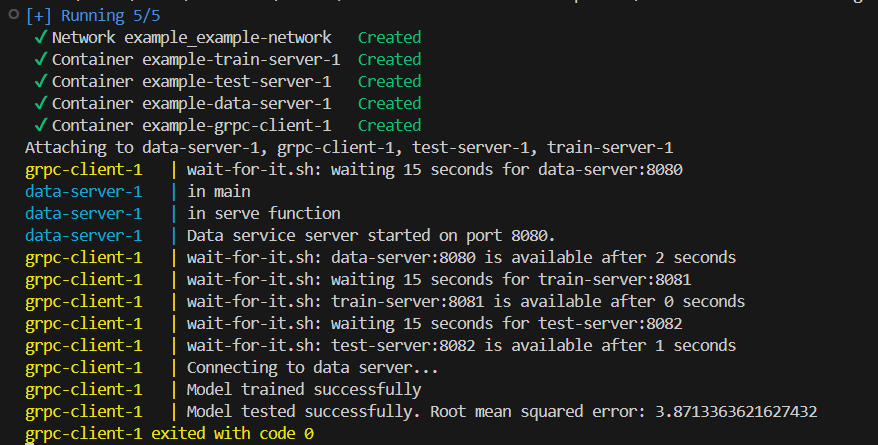

```shell
docker-compose up -d
```
for a detached session. In that case you can view the logs of each of the components using the command

```shell
docker-compose logs {container_name}
```






